In [1]:
import warnings
from jw_package import *
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

import configuration completed !
train + key + weather merging started
train + key + weather merging finished
function configuration completed ! 
Good to go !


모델링하기 전에 데이터의 복원에 대해서 고려해야 했다.

왜냐하면 제공받은 데이터엔 missing value가 많았기 때문이다.

그러면 완전한 데이터만 가지고 모델링하면 되지 않느냐,

그럴 수 없는 이유가 두가지 있다.

1. 완전한 데이터만 고려했을 때 빠진 store가 발생하기 때문에
2. 제공받은 데이터 중 완전한 데이터, 즉 일부만 사용한다면 편향된 결과를 도출할 수 있기 때문에

위 이유때문에 imputation을 해야만 했다.

---------------

우리가 세운 imputation의 기준은 총 3가지다.

1. yesterday = 어제 날짜를 참조하여 복원
2. mean = 해당 feature의 평균으로 복원
3. best close = missing 행과 가장 비슷한 행을 찾아 복원

모델링에 쓰일 데이터는 위의 세가지 복원버전을 사용한다.

--------------

우리의 종속변수는 units다.

이에 대해 고려해야 할 독립변수는 우리가 제공받은 weather데이터의 각 feature column들이다. 

(tavg, tmin, dewpoint, codesum etc 2~3개 정도로 간략하게 설명)

feature들은 실수형, 카테고리형 둘 다를 포함하고,

우리는 기본적으로 두 형태의 모델링으로 시작했다.

1. store_nbr, item_nbr별로 data를 filtering한 가중치
2. store_nbr, item_nbr를 카테고리 변수로 갖는 가중치

---------------

### 첫번째 경우
item_nbr로만 filtering / store_nbr,item_nbr로 filtering

모두 해봤는데 알스퀘어값이 상당히 낮았고 수치가 전체적으로 unstable했음

아마도 모수값을 계산하는데 원래 모든 데이터가 작용해야 하는데 filtering된 데이터가 편파적으로 작용하여 올바른 계산이 되지 않은 것으로 보인다 (방정식의 수 vs 미지수의 수)

타당한 모델링이 아닌 것 같아서 이 경우는 제외함

In [2]:
from pres_first import *
results=[0,]
total = 0
n = 0
for item_nbr in range(1,112):
    frame = data[data['item_nbr']==item_nbr]
    
    model = sm.OLS.from_formula(formula,data=frame)
    
    r2 = model.fit().rsquared
    
    if not np.isnan(r2):
#         print(item_nbr, r2)
        total+=r2
        n+=1
    
    if r2>=0.3:
        print(item_nbr,r2)
    
    results.append(model)

In [3]:
results[1].fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     17.72
Date:                Wed, 14 Mar 2018   Prob (F-statistic):           1.49e-26
Time:                        02:30:41   Log-Likelihood:                -7847.5
No. Observations:               11904   AIC:                         1.571e+04
Df Residuals:                   11895   BIC:                         1.578e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2229      0.040      5.594      0.000       0.145       0.301
depart         -0.0035      0.001     -5.503      0.000      -0.005      -0.002
dewpoint       -0.0036      0.001     -5.169      0.000      -0.005      -0.002
heat           -0.0059      0.001     -6.763      0.000      -0.008      -0.004
cool            0.0056      0.001      6.806      0.000       0.004       0.007
snowfall        0.0037      0.011      0.339      0.735      -0.018       0.025
preciptotal     0.0168      0.016      1.071      0.284      -0.014       0.047
resultspeed     0.0053      0.001      5.306      0.000       0.003       0.007
resultdir      -0.0005      0.000     -1.038      0.299      -0.001       0.000
==============================================================================
Omnibus:                    18688.681   Durbin-Watson:                   0.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8065953.723
Skew:                          10.280   Prob(JB):                         0.00
Kurtosis:                     128.854   Cond. No.                         527.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
# 각 item_nbr에 대한 모델의 알스퀘어값의 평균
total/n

0.023125162160689081

### 두번째 경우
얘는 script임. 발표할 때 따로 어디다 적어놓고 읽을 것
1. 카테고리로 store_nbr, item_nbr를 줬을 때 알스퀘어값이 0.6정도 나옴.

2. 이 상태에서 복원한 각 버전으로 아웃라이어 제거, VIF로 다중공선성 제거, 각 실수 독립변수에 대해 scaling, 변수변환으로 각각 모델링 시행.

3. 독립변수에 몇가지를 더 추가하여 트레이닝한 결과 평균적으로 알스퀘어 값이 0.85정도 나옴.

4. 크로스 벨리데이션으로 측정했을 때도 알스퀘어 값이 균일했음. 오버피팅이 일어나지 않음 (오버피팅 안일어났으니까 정규화도 안했음)

5. 위 모든 결과를 통틀어 잔차는 정규성을 따르지 않았고 LL값도 낮았다. 

6. 잔차가 정규성을 따르지 않는다는 결과는 우리의 모델링이 실제를 충분히 반영하고 있지 않기 때문에, 즉 적합한 회귀선을 찾지 못해서라고 판단

7. 그래서 구해진 모델에 대해 잔차가 정규성을 따르게 해주는 조치를 취해주는 것보단 실제를 충분히 반영하는 모델을 찾아야겠다고 판단

8. 그 전에 구한 모델의 결과에서 어느 독립변수가 어떻게 종속변수에 끼치는지 알아보기 위해 각 독립변수와 종속변수의 plot을 찍어봤다.

9. 그랬더니 모든 실수 독립변수가 종속변수와 무상관관계를 나타냈다.

10. 데이터 복원이 잘못 됬나 싶어 제공받은 데이터 중 intact한 애들로만 따로 결과내서 찍어보니 모양도 똑같고 무상관관계였다.
(데이터 복원은 없는 경향까지 만들어내지 않는다)

11. 앞서 도출한 바를 바탕으로 모델링에서 실수 독립변수를 제외하고 독립변수로 카테고리 값만 줬는데도 결과엔 아무런 영향이 없었다. 실수 독립변수는 종속변수와 상관없음.

12. 독립변수에 요일을 나타내는 카테고리 변수 dayofweek을 추가하여 모델링한 결과 성능이 올랐다.

13. units(판매량)은 날씨에 대해선 영향을 받지 않는다. 온도가 어떻다던지, 습도가 어떻다던지. 다만 dayofweek을 추가했을 땐 영향을 받았는데 요일을 고려했을 때 실제를 더 충분히 반영하는 모델링일 것이기 때문이다.

14. 

# 1.

In [5]:
from pres_second import *
formula = 'units ~ C(store_nbr) + C(item_nbr)+avgspeed + cool + depart + dewpoint + heat + preciptotal + resultdir + resultspeed + sealevel + snowfall + stnpressure + tavg + tmax + tmin + wetbulb'
model = sm.OLS.from_formula(formula,data=data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     986.1
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        02:30:51   Log-Likelihood:            -5.7703e+05
No. Observations:              118664   AIC:                         1.154e+06
Df Residuals:                  118494   BIC:                         1.156e+06
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            164.7663     22.489      7.327      0.000     120.689     208.844
C(store_nbr)[T.2]     31.9085      1.517     21.032      0.000      28.935      34.882
C(store_nbr)[T.3]     22.0171      1.476     14.919      0.000      19.125      24.910
C(store_nbr)[T.4]     77.4034      1.390     55.672      0.000      74.678      80.128
C(store_nbr)[T.5]     27.2883      1.256     21.718      0.000      24.826      29.751
C(store_nbr)[T.6]     16.7048      1.491     11.208      0.000      13.783      19.626
C(store_nbr)[T.7]     30.2248      1.328     22.761      0.000      27.622      32.827
C(store_nbr)[T.8]      8.7734      1.341      6.544      0.000       6.146      11.401
C(store_nbr)[T.9]     17.7730      1.251     14.212      0.000      15.322      20.224
C(store_nbr)[T.10]    31.2044      1.189     26.247      0.000      28.874      33.535
C(store_nbr)[T.11]    11.7275      1.186      9.892      0.000       9.404      14.051
C(store_nbr)[T.12]    33.9915      1.247     27.261      0.000      31.548      36.435
C(store_nbr)[T.13]    37.4243      1.297     28.848      0.000      34.882      39.967
C(store_nbr)[T.14]   -31.6264      1.228    -25.759      0.000     -34.033     -29.220
C(store_nbr)[T.15]    23.4677      4.239      5.536      0.000      15.159      31.777
C(store_nbr)[T.16]    52.1207      1.467     35.534      0.000      49.246      54.996
C(store_nbr)[T.17]    92.3502      1.270     72.738      0.000      89.862      94.839
C(store_nbr)[T.18]     4.7991      1.300      3.692      0.000       2.251       7.347
C(store_nbr)[T.19]    18.7430      1.390     13.484      0.000      16.019      21.467
C(store_nbr)[T.20]    36.3621      1.579     23.028      0.000      33.267      39.457
C(store_nbr)[T.21]    -2.5876      1.294     -2.000      0.046      -5.124      -0.051
C(store_nbr)[T.22]    15.5053      1.177     13.171      0.000      13.198      17.813
C(store_nbr)[T.23]    -6.2754      1.264     -4.964      0.000      -8.753      -3.797
C(store_nbr)[T.24]    83.3704      4.574     18.228      0.000      74.406      92.335
C(store_nbr)[T.25]    33.5811      4.237      7.926      0.000      25.277      41.885
C(store_nbr)[T.26]     6.6004      1.257      5.251      0.000       4.137       9.064
C(store_nbr)[T.27]    10.0174      1.161      8.631      0.000       7.743      12.292
C(store_nbr)[T.28]     2.8966      1.506      1.924      0.054      -0.054       5.847
C(store_nbr)[T.29]    18.3121      1.361     13.451      0.000      15.644      20.980
C(store_nbr)[T.30]    46.5242      1.320     35.233      0.000      43.936      49.112
C(store_nbr)[T.31]    25.4737      1.199     21.240      0.000      23.123      27.824
C(store_nbr)[T.32]    -3.8806      4.231     -0.917      0.359     -12.173       4.411
C(store_nbr)[T.33]    87.6211      1.2

# 2. 아웃라이어 제거 (R2)

In [6]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
data.drop(list(drop_index),inplace=True)
data.reset_index(drop=True,inplace=True)

model = sm.OLS.from_formula(formula,data=data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     2114.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        02:30:54   Log-Likelihood:            -5.0032e+05
No. Observations:              115306   AIC:                         1.001e+06
Df Residuals:                  115136   BIC:                         1.003e+06
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            121.5137     13.518      8.989      0.000      95.019     148.008
C(store_nbr)[T.2]     32.2192      0.911     35.375      0.000      30.434      34.004
C(store_nbr)[T.3]     20.5228      0.880     23.313      0.000      18.797      22.248
C(store_nbr)[T.4]     68.8060      0.881     78.063      0.000      67.078      70.534
C(store_nbr)[T.5]     21.0400      0.750     28.036      0.000      19.569      22.511
C(store_nbr)[T.6]     16.0819      0.888     18.105      0.000      14.341      17.823
C(store_nbr)[T.7]     27.8027      0.797     34.898      0.000      26.241      29.364
C(store_nbr)[T.8]      7.6893      0.801      9.604      0.000       6.120       9.259
C(store_nbr)[T.9]     17.8635      0.745     23.969      0.000      16.403      19.324
C(store_nbr)[T.10]    25.7370      0.713     36.111      0.000      24.340      27.134
C(store_nbr)[T.11]    11.1026      0.705     15.750      0.000       9.721      12.484
C(store_nbr)[T.12]    27.7975      0.745     37.322      0.000      26.338      29.257
C(store_nbr)[T.13]    34.7049      0.778     44.621      0.000      33.181      36.229
C(store_nbr)[T.14]   -29.1331      0.735    -39.642      0.000     -30.574     -27.693
C(store_nbr)[T.15]    22.5411      2.518      8.951      0.000      17.605      27.477
C(store_nbr)[T.16]    43.7971      0.877     49.926      0.000      42.078      45.517
C(store_nbr)[T.17]    79.1769      0.791    100.096      0.000      77.627      80.727
C(store_nbr)[T.18]     3.4715      0.775      4.481      0.000       1.953       4.990
C(store_nbr)[T.19]    14.1198      0.828     17.049      0.000      12.497      15.743
C(store_nbr)[T.20]    30.0403      0.949     31.644      0.000      28.180      31.901
C(store_nbr)[T.21]     1.7042      0.777      2.194      0.028       0.182       3.227
C(store_nbr)[T.22]    14.2855      0.701     20.375      0.000      12.911      15.660
C(store_nbr)[T.23]    -5.1123      0.752     -6.795      0.000      -6.587      -3.638
C(store_nbr)[T.24]    71.2706      2.761     25.815      0.000      65.859      76.682
C(store_nbr)[T.25]    32.7934      2.517     13.028      0.000      27.860      37.727
C(store_nbr)[T.26]     6.5035      0.750      8.676      0.000       5.034       7.973
C(store_nbr)[T.27]     8.9973      0.690     13.035      0.000       7.644      10.350
C(store_nbr)[T.28]     3.9478      0.896      4.407      0.000       2.192       5.704
C(store_nbr)[T.29]    16.1603      0.811     19.932      0.000      14.571      17.749
C(store_nbr)[T.30]    38.8688      0.816     47.606      0.000      37.269      40.469
C(store_nbr)[T.31]    24.6386      0.714     34.502      0.000      23.239      26.038
C(store_nbr)[T.32]    -0.2246      2.512     -0.089      0.929      -5.148       4.699
C(store_nbr)[T.33]    87.0630      0.8

In [7]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
data.drop(list(drop_index),inplace=True)
data.reset_index(drop=True,inplace=True)

model = sm.OLS.from_formula(formula,data=data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     2823.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        02:30:56   Log-Likelihood:            -4.3579e+05
No. Observations:              107773   AIC:                         8.719e+05
Df Residuals:                  107603   BIC:                         8.736e+05
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             87.7424     10.419      8.421      0.000      67.321     108.164
C(store_nbr)[T.2]     32.5640      0.703     46.307      0.000      31.186      33.942
C(store_nbr)[T.3]     18.7949      0.669     28.078      0.000      17.483      20.107
C(store_nbr)[T.4]     70.3633      0.763     92.163      0.000      68.867      71.860
C(store_nbr)[T.5]     16.0363      0.568     28.214      0.000      14.922      17.150
C(store_nbr)[T.6]     15.4680      0.675     22.899      0.000      14.144      16.792
C(store_nbr)[T.7]     24.9773      0.616     40.516      0.000      23.769      26.186
C(store_nbr)[T.8]      6.6764      0.608     10.983      0.000       5.485       7.868
C(store_nbr)[T.9]     17.5459      0.567     30.926      0.000      16.434      18.658
C(store_nbr)[T.10]    20.8023      0.546     38.096      0.000      19.732      21.873
C(store_nbr)[T.11]    10.8449      0.535     20.282      0.000       9.797      11.893
C(store_nbr)[T.12]    22.4495      0.565     39.757      0.000      21.343      23.556
C(store_nbr)[T.13]    33.1875      0.600     55.344      0.000      32.012      34.363
C(store_nbr)[T.14]   -31.4788      0.590    -53.390      0.000     -32.634     -30.323
C(store_nbr)[T.15]    21.5585      1.890     11.405      0.000      17.854      25.264
C(store_nbr)[T.16]    33.4808      0.674     49.705      0.000      32.161      34.801
C(store_nbr)[T.17]    70.8306      0.627    112.937      0.000      69.601      72.060
C(store_nbr)[T.18]     1.9824      0.585      3.388      0.001       0.836       3.129
C(store_nbr)[T.19]     9.7288      0.626     15.536      0.000       8.501      10.956
C(store_nbr)[T.20]    26.8148      0.730     36.716      0.000      25.383      28.246
C(store_nbr)[T.21]     4.7537      0.597      7.956      0.000       3.583       5.925
C(store_nbr)[T.22]    13.9316      0.534     26.074      0.000      12.884      14.979
C(store_nbr)[T.23]    -4.1230      0.569     -7.246      0.000      -5.238      -3.008
C(store_nbr)[T.24]    72.0659      2.106     34.214      0.000      67.938      76.194
C(store_nbr)[T.25]    31.1483      1.891     16.475      0.000      27.443      34.854
C(store_nbr)[T.26]     5.6071      0.570      9.841      0.000       4.490       6.724
C(store_nbr)[T.27]     8.3955      0.522     16.097      0.000       7.373       9.418
C(store_nbr)[T.28]     3.9175      0.677      5.785      0.000       2.590       5.245
C(store_nbr)[T.29]    15.7149      0.615     25.538      0.000      14.509      16.921
C(store_nbr)[T.30]    28.9615      0.638     45.420      0.000      27.712      30.211
C(store_nbr)[T.31]    24.4415      0.547     44.696      0.000      23.370      25.513
C(store_nbr)[T.32]     1.7543      1.883      0.932      0.352      -1.937       5.445
C(store_nbr)[T.33]    88.3062      0.6

# 2. 다중공선성 제거 (조건수)

In [8]:
tmp = data.copy()
del tmp['tavg']
del tmp['sealevel']
del tmp['wetbulb']
del tmp['stnpressure']
del tmp['tmin']
del tmp['tmax']
del tmp['dewpoint']
del tmp['avgspeed']
del tmp['resultspeed']

In [9]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(depart) + scale(heat) + scale(preciptotal) + scale(resultdir) + scale(snowfall)'
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     2976.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        02:31:03   Log-Likelihood:            -4.3588e+05
No. Observations:              107773   AIC:                         8.721e+05
Df Residuals:                  107612   BIC:                         8.736e+05
Df Model:                         160                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.8900      0.969     10.208      0.000       7.991      11.789
C(store_nbr)[T.2]     32.2752      0.577     55.909      0.000      31.144      33.407
C(store_nbr)[T.3]     18.4788      0.537     34.440      0.000      17.427      19.530
C(store_nbr)[T.4]     70.2962      0.737     95.331      0.000      68.851      71.741
C(store_nbr)[T.5]     15.5926      0.565     27.575      0.000      14.484      16.701
C(store_nbr)[T.6]     15.1796      0.543     27.969      0.000      14.116      16.243
C(store_nbr)[T.7]     24.4475      0.602     40.642      0.000      23.269      25.627
C(store_nbr)[T.8]      6.7923      0.581     11.699      0.000       5.654       7.930
C(store_nbr)[T.9]     17.4858      0.539     32.437      0.000      16.429      18.542
C(store_nbr)[T.10]    20.3491      0.543     37.479      0.000      19.285      21.413
C(store_nbr)[T.11]    10.2898      0.530     19.410      0.000       9.251      11.329
C(store_nbr)[T.12]    21.8384      0.560     38.982      0.000      20.740      22.936
C(store_nbr)[T.13]    32.6748      0.584     55.923      0.000      31.530      33.820
C(store_nbr)[T.14]   -31.6744      0.589    -53.744      0.000     -32.830     -30.519
C(store_nbr)[T.15]    23.7399      0.525     45.235      0.000      22.711      24.769
C(store_nbr)[T.16]    33.5463      0.600     55.939      0.000      32.371      34.722
C(store_nbr)[T.17]    70.7125      0.599    118.056      0.000      69.539      71.887
C(store_nbr)[T.18]     1.9217      0.558      3.445      0.001       0.828       3.015
C(store_nbr)[T.19]     9.7322      0.622     15.656      0.000       8.514      10.951
C(store_nbr)[T.20]    26.5064      0.610     43.461      0.000      25.311      27.702
C(store_nbr)[T.21]     4.3675      0.566      7.713      0.000       3.258       5.477
C(store_nbr)[T.22]    13.3737      0.530     25.243      0.000      12.335      14.412
C(store_nbr)[T.23]    -4.1819      0.541     -7.732      0.000      -5.242      -3.122
C(store_nbr)[T.24]    72.2979      2.098     34.456      0.000      68.185      76.410
C(store_nbr)[T.25]    33.3161      0.528     63.119      0.000      32.282      34.351
C(store_nbr)[T.26]     5.5440      0.542     10.238      0.000       4.483       6.605
C(store_nbr)[T.27]     7.8402      0.517     15.168      0.000       6.827       8.853
C(store_nbr)[T.28]     3.6159      0.546      6.620      0.000       2.545       4.686
C(store_nbr)[T.29]    15.3254      0.585     26.199      0.000      14.179      16.472
C(store_nbr)[T.30]    28.8353      0.607     47.473      0.000      27.645      30.026
C(store_nbr)[T.31]    24.3867      0.517     47.149      0.000      23.373      25.400
C(store_nbr)[T.32]     3.9422      0.495      7.962      0.000       2.972       4.913
C(store_nbr)[T.33]    87.9366      0.6

# 3. 추가한 독립변수 is_holiday, codesum

In [10]:
tmp = tmp.merge(codesum, on = ['date','store_nbr'])
tmp['is_holiday'] = tmp['is_holiday'].apply(cate_holiday)
tmp['codesum'] = tmp['codesum'].apply(cate_codesum)
formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'

In [11]:
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     3099.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        02:31:08   Log-Likelihood:            -4.3438e+05
No. Observations:              107773   AIC:                         8.691e+05
Df Residuals:                  107613   BIC:                         8.706e+05
Df Model:                         159                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.3657      0.956      8.752      0.000       6.492      10.239
C(store_nbr)[T.2]     32.3800      0.569     56.881      0.000      31.264      33.496
C(store_nbr)[T.3]     18.4968      0.529     34.959      0.000      17.460      19.534
C(store_nbr)[T.4]     70.5825      0.727     97.069      0.000      69.157      72.008
C(store_nbr)[T.5]     15.6339      0.557     28.045      0.000      14.541      16.727
C(store_nbr)[T.6]     15.0667      0.535     28.153      0.000      14.018      16.116
C(store_nbr)[T.7]     24.5012      0.593     41.314      0.000      23.339      25.664
C(store_nbr)[T.8]      6.8147      0.572     11.904      0.000       5.693       7.937
C(store_nbr)[T.9]     17.4300      0.531     32.806      0.000      16.389      18.471
C(store_nbr)[T.10]    20.4501      0.535     38.205      0.000      19.401      21.499
C(store_nbr)[T.11]    10.2481      0.523     19.605      0.000       9.224      11.273
C(store_nbr)[T.12]    21.9196      0.552     39.697      0.000      20.837      23.002
C(store_nbr)[T.13]    32.7728      0.576     56.892      0.000      31.644      33.902
C(store_nbr)[T.14]   -31.9497      0.581    -55.003      0.000     -33.088     -30.811
C(store_nbr)[T.15]    23.9530      0.517     46.301      0.000      22.939      24.967
C(store_nbr)[T.16]    33.7100      0.591     57.033      0.000      32.551      34.868
C(store_nbr)[T.17]    70.7917      0.591    119.858      0.000      69.634      71.949
C(store_nbr)[T.18]     1.9015      0.550      3.458      0.001       0.824       2.979
C(store_nbr)[T.19]     9.8498      0.613     16.078      0.000       8.649      11.051
C(store_nbr)[T.20]    26.5568      0.601     44.157      0.000      25.378      27.736
C(store_nbr)[T.21]     4.2661      0.558      7.640      0.000       3.172       5.361
C(store_nbr)[T.22]    13.3526      0.522     25.559      0.000      12.329      14.377
C(store_nbr)[T.23]    -4.3301      0.533     -8.123      0.000      -5.375      -3.285
C(store_nbr)[T.24]    72.8993      2.069     35.230      0.000      68.844      76.955
C(store_nbr)[T.25]    33.3538      0.520     64.108      0.000      32.334      34.373
C(store_nbr)[T.26]     5.4353      0.534     10.184      0.000       4.389       6.481
C(store_nbr)[T.27]     7.8058      0.510     15.315      0.000       6.807       8.805
C(store_nbr)[T.28]     3.5208      0.539      6.537      0.000       2.465       4.576
C(store_nbr)[T.29]    15.2879      0.577     26.502      0.000      14.157      16.419
C(store_nbr)[T.30]    28.9756      0.599     48.378      0.000      27.802      30.150
C(store_nbr)[T.31]    24.4377      0.510     47.942      0.000      23.439      25.437
C(store_nbr)[T.32]     3.8734      0.488      7.937      0.000       2.917       4.830
C(store_nbr)[T.33]    87.9720      0.6

# 4. cross-validation

In [12]:
X = tmp.loc[:, ['store_nbr', 'item_nbr', 'cool', 'heat', 'preciptotal','snowfall', 'is_holiday']]
y = tmp.loc[:, ['units']]

from sklearn.model_selection import KFold

trial = 4

cv = KFold(n_splits=trial, shuffle=True, random_state=2)

total = 0


for train_index, test_index in cv.split(X):
    print("test index :", test_index, len(test_index))
    print("." * 80)
    print("train index:", train_index, len(train_index))
    print("=" * 80)

    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index, :]
    y_train = y.loc[train_index, :]
    y_test = y.loc[test_index, :]

    model = sm.OLS.from_formula(
        formula, data=pd.concat([X_train, y_train], axis=1))
    result = model.fit()

    y_hat = result.predict(X_test)

    ESS = ((y_hat - y_hat.mean())**2).sum()
    TSS = ((y_test - y_test.mean())**2).sum()
    total += ESS / TSS
    print(ESS / TSS)

total / trial

test index : [     4      7      9 ..., 107769 107771 107772] 26944
................................................................................
train index: [     0      1      2 ..., 107767 107768 107770] 80829
units    0.818588
dtype: float64
test index : [     0      1      2 ..., 107752 107760 107765] 26943
................................................................................
train index: [     3      4      5 ..., 107770 107771 107772] 80830
units    0.814344
dtype: float64
test index : [     5      6      8 ..., 107764 107766 107770] 26943
................................................................................
train index: [     0      1      2 ..., 107769 107771 107772] 80830
units    0.825617
dtype: float64
test index : [     3     12     15 ..., 107757 107767 107768] 26943
................................................................................
train index: [     0      1      2 ..., 107770 107771 107772] 80830
units    0.82395
dtype: float64


units    0.820625
dtype: float64

# 5. 잔차의 정규성, LL

In [13]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     2312.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        02:31:25   Log-Likelihood:            -3.2584e+05
No. Observations:               80830   AIC:                         6.520e+05
Df Residuals:                   80670   BIC:                         6.535e+05
Df Model:                         159                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.1077      1.099      7.375      0.000       5.953      10.263
C(store_nbr)[T.2]     32.3806      0.654     49.479      0.000      31.098      33.663
C(store_nbr)[T.3]     18.5742      0.609     30.491      0.000      17.380      19.768
C(store_nbr)[T.4]     70.9726      0.845     83.981      0.000      69.316      72.629
C(store_nbr)[T.5]     15.8024      0.640     24.679      0.000      14.547      17.057
C(store_nbr)[T.6]     14.9759      0.614     24.385      0.000      13.772      16.180
C(store_nbr)[T.7]     24.6793      0.679     36.330      0.000      23.348      26.011
C(store_nbr)[T.8]      7.1734      0.660     10.862      0.000       5.879       8.468
C(store_nbr)[T.9]     17.3280      0.608     28.490      0.000      16.136      18.520
C(store_nbr)[T.10]    20.7413      0.613     33.853      0.000      19.540      21.942
C(store_nbr)[T.11]    10.1824      0.600     16.957      0.000       9.005      11.359
C(store_nbr)[T.12]    22.3123      0.634     35.214      0.000      21.070      23.554
C(store_nbr)[T.13]    32.9680      0.656     50.248      0.000      31.682      34.254
C(store_nbr)[T.14]   -31.7510      0.668    -47.541      0.000     -33.060     -30.442
C(store_nbr)[T.15]    24.3648      0.592     41.159      0.000      23.205      25.525
C(store_nbr)[T.16]    33.5656      0.680     49.372      0.000      32.233      34.898
C(store_nbr)[T.17]    70.6186      0.677    104.312      0.000      69.292      71.945
C(store_nbr)[T.18]     1.9784      0.632      3.129      0.002       0.739       3.218
C(store_nbr)[T.19]     9.6907      0.707     13.716      0.000       8.306      11.076
C(store_nbr)[T.20]    26.2362      0.691     37.954      0.000      24.881      27.591
C(store_nbr)[T.21]     4.4027      0.644      6.832      0.000       3.140       5.666
C(store_nbr)[T.22]    13.4448      0.598     22.496      0.000      12.273      14.616
C(store_nbr)[T.23]    -4.5797      0.614     -7.463      0.000      -5.782      -3.377
C(store_nbr)[T.24]    74.1266      2.346     31.600      0.000      69.529      78.724
C(store_nbr)[T.25]    33.3693      0.596     56.012      0.000      32.202      34.537
C(store_nbr)[T.26]     5.4268      0.612      8.865      0.000       4.227       6.627
C(store_nbr)[T.27]     7.5764      0.584     12.970      0.000       6.431       8.721
C(store_nbr)[T.28]     3.3634      0.619      5.434      0.000       2.150       4.577
C(store_nbr)[T.29]    15.0080      0.663     22.629      0.000      13.708      16.308
C(store_nbr)[T.30]    28.5052      0.686     41.545      0.000      27.160      29.850
C(store_nbr)[T.31]    24.3349      0.588     41.352      0.000      23.181      25.488
C(store_nbr)[T.32]     3.7577      0.560      6.710      0.000       2.660       4.855
C(store_nbr)[T.33]    88.1588      0.7

# 8,9,10. 실수 독립변수 vs 종속변수

In [14]:
formula

'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'

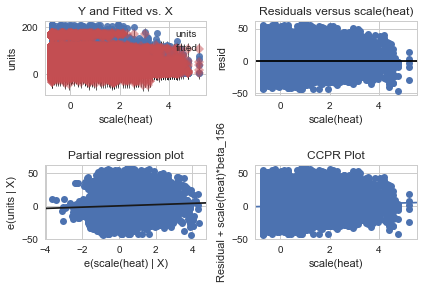

In [15]:
fig = sm.graphics.plot_regress_exog(result, "scale(heat)")
fig.suptitle("")
plt.show()

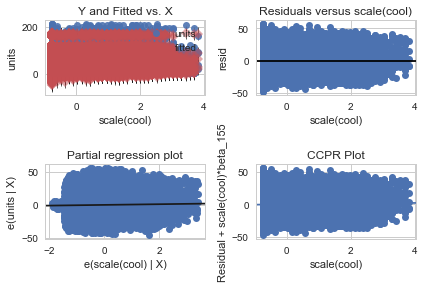

In [16]:
fig = sm.graphics.plot_regress_exog(result, "scale(cool)")
fig.suptitle("")
plt.show()

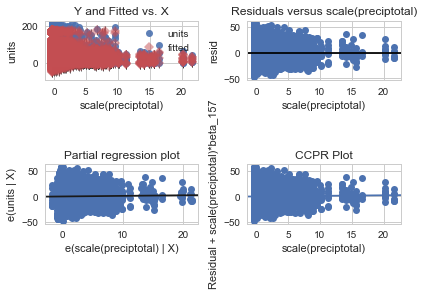

In [17]:
fig = sm.graphics.plot_regress_exog(result, "scale(preciptotal)")
fig.suptitle("")
plt.show()

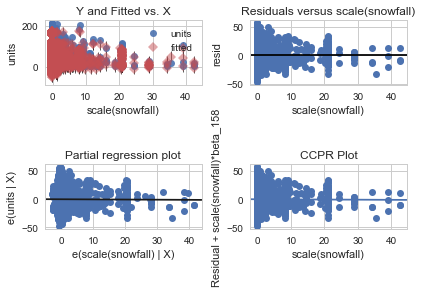

In [18]:
fig = sm.graphics.plot_regress_exog(result, "scale(snowfall)")
fig.suptitle("")
plt.show()

# 11. 카테고리 독립변수만 고려 (R2에 큰 차이가 없음)

In [19]:
formula = 'units ~ C(store_nbr) + C(item_nbr)'
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     3082.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        02:31:46   Log-Likelihood:            -4.3602e+05
No. Observations:              107773   AIC:                         8.723e+05
Df Residuals:                  107618   BIC:                         8.738e+05
Df Model:                         154                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.9285      0.970     10.236      0.000       8.027      11.830
C(store_nbr)[T.2]     32.1105      0.577     55.609      0.000      30.979      33.242
C(store_nbr)[T.3]     18.3696      0.536     34.241      0.000      17.318      19.421
C(store_nbr)[T.4]     70.5786      0.738     95.628      0.000      69.132      72.025
C(store_nbr)[T.5]     15.2385      0.564     27.021      0.000      14.133      16.344
C(store_nbr)[T.6]     15.0179      0.543     27.672      0.000      13.954      16.082
C(store_nbr)[T.7]     24.1937      0.601     40.273      0.000      23.016      25.371
C(store_nbr)[T.8]      6.5531      0.579     11.312      0.000       5.418       7.688
C(store_nbr)[T.9]     17.3511      0.539     32.197      0.000      16.295      18.407
C(store_nbr)[T.10]    19.9788      0.541     36.908      0.000      18.918      21.040
C(store_nbr)[T.11]     9.9827      0.528     18.909      0.000       8.948      11.017
C(store_nbr)[T.12]    21.4517      0.559     38.376      0.000      20.356      22.547
C(store_nbr)[T.13]    32.4373      0.584     55.589      0.000      31.294      33.581
C(store_nbr)[T.14]   -31.6049      0.590    -53.593      0.000     -32.761     -30.449
C(store_nbr)[T.15]    23.7513      0.525     45.225      0.000      22.722      24.781
C(store_nbr)[T.16]    33.5944      0.600     56.002      0.000      32.419      34.770
C(store_nbr)[T.17]    70.5457      0.598    117.951      0.000      69.373      71.718
C(store_nbr)[T.18]     1.8158      0.558      3.256      0.001       0.723       2.909
C(store_nbr)[T.19]     9.9015      0.622     15.928      0.000       8.683      11.120
C(store_nbr)[T.20]    26.3913      0.610     43.265      0.000      25.196      27.587
C(store_nbr)[T.21]     4.2498      0.566      7.504      0.000       3.140       5.360
C(store_nbr)[T.22]    13.0976      0.528     24.822      0.000      12.063      14.132
C(store_nbr)[T.23]    -4.3183      0.541     -7.987      0.000      -5.378      -3.259
C(store_nbr)[T.24]    72.5079      2.101     34.512      0.000      68.390      76.626
C(store_nbr)[T.25]    33.2787      0.528     63.005      0.000      32.244      34.314
C(store_nbr)[T.26]     5.4146      0.541     10.002      0.000       4.354       6.476
C(store_nbr)[T.27]     7.5514      0.515     14.671      0.000       6.543       8.560
C(store_nbr)[T.28]     3.5116      0.546      6.430      0.000       2.441       4.582
C(store_nbr)[T.29]    15.1893      0.585     25.962      0.000      14.043      16.336
C(store_nbr)[T.30]    29.0026      0.608     47.716      0.000      27.811      30.194
C(store_nbr)[T.31]    24.2253      0.517     46.868      0.000      23.212      25.238
C(store_nbr)[T.32]     3.9297      0.495      7.932      0.000       2.959       4.901
C(store_nbr)[T.33]    87.8428      0.6

# 12. dayofweek 추가